# [0] Imports

In [1]:
import Pkg;

using LinearAlgebra, Random, Gurobi, JuMP, Distributions, Plots, LazySets

# [1] Setup

## [1a] Initialize variables
Many parameters need to be set up and initialized so they can be called upon later in the code according to the Overleaf document.

In [34]:
n_jobs = 25
n_vehicles_jobs = 15
n_vehicles_coverage = 10

#Optimization over 6 hours with a time-step of 10 minutes, T = # of timesteps
T = 50

#=
The following definitions help with code for our problem
and are not found in the formulation, 
but indirectly necessary when calculated by parameters
=#

#Minimal length of a job is two-time period
min_duration = 2
max_duration = 6
#Speed is in m/10minutes = m/interval
speed = 1000/6
#Radius for coverage is 50m
coverage_distance = 50
#Size of the square for jobs location in meters
size = 500
#Size of the mesh for the coverage vehicles locations
step = 50;

## [1b] Create locations and time-windows 

I will put many of these initialization parts into functions.

We create clusters to beautify the problem - rather than truly random task locations we give it some structure. This is just an element of our artificial data!

In [30]:
# We set the seed so that we always have the same result
Random.seed!(1234)

#=
Our 'creative' strategy is to create jobs in small clusters.
Then, for each cluster, we include some variation on the locations
of the job.
=#

function create_cluster_sizes(jobs_total)
    #=
    Given a total number of jobs we need to create, 
    creates cluster SIZES. For instance, if we have 15 jobs,
    one possible output is 3, 4, 5, 3.
    
    returns cluster, which is an array listing the sizes of clusters.
    =#
    jobs_created = 0
    cluster = []
    while jobs_created != jobs_total
        num_to_add = rand(min(3, jobs_total - jobs_created) : 
            min(floor(Int, jobs_total / 5) + 1, jobs_total - jobs_created))
        jobs_created += num_to_add
        push!(cluster, num_to_add)
    end
    
    return cluster
end

create_cluster_sizes (generic function with 1 method)

In [28]:
# testing
create_cluster_sizes(16)

5-element Vector{Any}:
 4
 3
 3
 4
 2

In [46]:
# Create job and depot locations, time windows and work load for each job.
time_windows = []
locations = rand(Uniform(0,size), 1, 2)
work_load = []
#=
time_windows is a list of tuples, with each tuple [s, e] specifying
when a job must be performed, between s and e inclusive.

work_load represents the duration of the job.

time_windows tuple is the ONLY time the job can be completed.
The job must be completed sometime *within* time_windows tuple.

Note that sometimes, the tuple specifies exactly the time
when we must work at that job, while other times,
there is more flexibility because the tuple is particularly long
compared to the work_load duration.
=#

cluster = create_cluster_sizes(n_jobs)

5-element Vector{Any}:
 5
 6
 6
 3
 5

### Function to Create Time Windows and Work Load

Critical parameters for the algorithm later on. We will create both the time windows allotted, as well as the time it takes to finish each job.

In [47]:
function create_time_windows_and_work_load(cluster_sizes, locations)
    #=
    parameters to pass in.
    Realistically these should be put as parameters in the function 
    signature, but we can do this for ease...nothing too bad
    
    Returns time windows of the form [ [start, end], ...]
    work_load of the durations of each job e.g. [5, 6, 4..]
    locations
    =#
    locations = rand(Uniform(0,size), 1, 2)
    for size_c in cluster
        first = rand(Uniform(0,size), 1, 2)
        locations = vcat(locations, first)

        job_begins = rand(2:10)
        job_finish = rand((job_begins+min_duration):(job_begins+max_duration))
        push!(time_windows, [job_begins, job_finish])

        time_work = rand(min_duration:max(min_duration, job_finish - job_begins))
        push!(work_load, time_work)

        for neighbour in 1:(size_c-1)
            new_x = rand(Uniform(max(0,first[1]-20), min(first[1]+20, size)), 1, 1)
            new_y = rand(Uniform(max(0,first[2]-20), min(first[2]+20, size)), 1, 1)
            new = hcat(new_x, new_y)
            locations = vcat(locations, new)

            job_begins = rand(job_finish:min(T-min_duration-2, job_finish + 6))
            job_finish = rand((job_begins+min_duration):(min(job_begins+max_duration, T-2)))
            push!(time_windows, [job_begins, job_finish])

            time_work = rand(min_duration:min(max_duration, job_finish-job_begins))
            push!(work_load, time_work)
        end
    end
    
    return [time_windows, work_load, locations]
end

In [51]:
time_windows, work_load, locations = create_time_windows_and_work_load(cluster, locations)
#=
now, 

time_windows looks like [ [8, 10], [16, 21], ... , [16, 21]]

work_load looks like [2, 5, 2, 4, 2, 2, ..., 2, 5]
=#

#Compute distances between each locations created
distances = [LinearAlgebra.norm(locations[i, :] .- locations[j, :]) for i=1:n_jobs+1, j = 1:n_jobs+1];

print("Time Windows: ", time_windows, "\n")
print("Work Loads: ", work_load, "\n")

Time Windows: Any[[2, 5], [7, 13], [16, 19], [19, 23], [27, 31], [10, 14], [20, 24], [25, 27], [27, 30], [36, 42], [45, 48], [6, 9], [10, 14], [15, 17], [22, 25], [29, 34], [38, 44], [5, 9], [13, 16], [21, 26], [9, 14], [19, 21], [26, 29], [29, 33], [35, 40], [8, 10], [15, 21], [21, 24], [27, 31], [32, 37], [3, 8], [13, 18], [24, 28], [30, 35], [38, 44], [44, 47], [9, 14], [14, 17], [19, 23], [27, 29], [32, 35], [39, 44], [9, 12], [13, 16], [21, 23], [6, 11], [16, 20], [24, 29], [31, 35], [40, 44], [4, 8], [8, 13], [13, 19], [25, 29], [35, 38], [8, 14], [17, 21], [22, 28], [31, 34], [37, 41], [43, 47], [3, 8], [11, 15], [20, 24], [25, 27], [31, 35], [40, 43], [4, 10], [10, 12], [18, 24], [10, 14], [17, 23], [23, 27], [33, 36], [41, 47], [3, 7], [11, 13], [14, 18], [22, 28], [31, 37], [6, 10], [10, 16], [16, 21], [25, 28], [30, 33], [39, 45], [2, 5], [6, 11], [17, 21], [25, 29], [34, 37], [39, 41], [3, 6], [7, 11], [13, 15], [9, 15], [17, 21], [23, 25], [28, 30], [31, 35]]
Work Loads: A

In [84]:
# locations - these are Cartesian coordinates telling us where stations are in the plane
print("Locations: ", locations, "\n")

Locations: [318.7348760600243 309.8511894728042; 409.8396829781945 471.0606169001269; 413.9330980885311 473.3000045221094; 394.09086721777453 464.28170943801547; 426.8907091757432 464.150778494994; 390.539365740374 458.73437243543265; 50.66010041639368 472.21518107980825; 70.43674365860144 479.36236715745713; 55.49732425881798 489.7419145344903; 57.061886788387994 466.5465145383949; 34.68551837237168 452.9956436103775; 35.270113860988985 462.2676823720703; 15.252191921314552 229.98919390540067; 6.893852859075727 245.4056075271678; 29.38710926471096 238.83075563046256; 23.920121390614007 244.15397088759136; 5.2279674253960655 222.15834228388846; 2.3457058779997113 222.08365976523228; 328.8310057424593 460.1199259818831; 330.41526798792916 479.9044953831515; 341.8618970696543 445.8802558335132; 244.21693845829762 43.895806990129294; 234.37857034174357 61.99918941572368; 224.91523236405249 27.078684012982503; 253.61919104514953 30.321211607660384; 232.5527948315421 23.91424852556743]


### A little exercise: plot the task locations

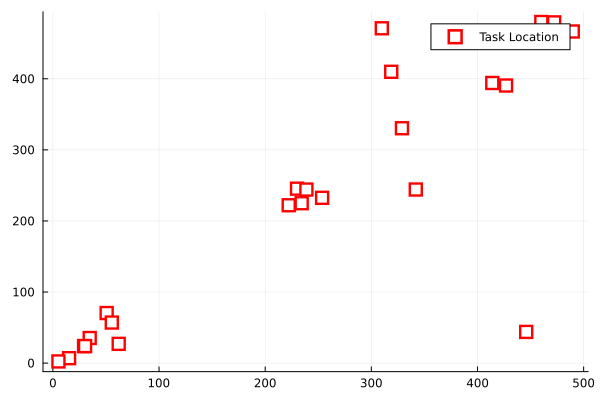

In [89]:
# let's do a little JuMP exercise of plotting the locations.
x_values = []
y_values = []
for i in 1:Int(length(locations) / 2)
    push!(x_values, locations[i * 2 - 1])
    push!(y_values, locations[i*2])
end

Plots.scatter(x_values, y_values; label = "Task Location", markershape = :square, 
markercolor = :white, markersize = 6, markerstrokecolor = :red, markerstrokewidth = 3)

In [91]:
# normalization and checking: make sure that T is truly the largest we need
max_t = 0
for window in time_windows
    if window[2] > max_t
        max_t = window[2]
    end
end
T = min(50, max_t + 8);
#T is still 50

print("T is ", T)

T is 50

## [1c] Create the time-space network for jobs

### Create node network

In [93]:
#=
Create the node network

This will be of the form
[ [location, time] ...]

which is a full rendition of all possible 
locations and times

so there will be (total time - 2) * location
nodes.

This will create a time-space network not including
the very first and very last time,
because those have time 1 = location 0 and time 50 = location 26
by default. So we don't need to put it in here.
=#
function create_node_network(n_jobs, T)
    nodes = []
    for i in 1:n_jobs
        for t in 2:(T-1)
            push!(nodes, [i, t])
        end
    end
    return nodes
end

create_node_network (generic function with 1 method)

### Create Arc System

This is more complicated and involves three stages.

First: leaving the depot

Second: between jobs

Third: coming back into the depot.

It is assumed that no vehicle will do depot -> job -> depot -> job...
because it is inefficient. 

We just go depot -> job -> back to depot.
(job can consist of multiple jobs)

In [94]:
function create_arc_system(n_jobs, distances, speed, time_windows, nodes)
    #=
    Create a full arc system which has the format
    [ [initial_i, initial_t], [end_i, end_t], distance]
    
    remember: distance is like our cost, the first two elements represent the movement
    =#
    
    arcs = []
    
    #leaving the depot
    for n in nodes
        dist = distances[1, n[1] + 1]
        max_t = 0
        for t in 1:n[2]
            if n[2] > (t + dist/speed)
                max_t = t
            end
        end
        push!(arcs, [[0, max_t], n, dist])
    end
    
    #between two jobs
    for n1 in nodes
        already = []
        for n2 in nodes
            dist = distances[n1[1]+1, n2[1]+1]
            
            #=
            only add arc from node n1 = [i1, t1] to n2 = [i2, t2] if:
            1) it is possible to get from n1 to n2 within the given timeframe (time = dist / speed)
            2) the nodes do not have the same job location - this is covered in elseif
            3) n2 is not already covered in our node network - it won't be a superfluous addition
            4) n2's time is worth going to: we have enough time left to get there to do the job
            
            condition 4 example: If current time is 15, time window is [13, 20], and the work load 
            (time required) is 6 hours, then don't bother going to the job - it's a waste of time
            =#
            if (n2[2] > n1[2] + dist/speed) & 
                (n2[1] != n1[1]) & 
                (!(n2[1] in  already)) & 
                (n2[2] <= (time_windows[n2[1]][2] - work_load[n2[1]]))
                push!(arcs, [n1, n2, dist])
                push!(already, n2[1]) #already visited so we don't do it again: algorithmic efficiency
                
            elseif (n2[2] == n1[2] + 1) & (n2[1] == n1[1])
                push!(arcs, [n1, n2, dist])
                
            end
        end
    end
    
    #Back to the depot
    for n in nodes
        dist = distances[1, n[1] + 1]
        min_t = T+1
        for t in T:-1:1
            if t > (n[2]+dist/speed)
                min_t = t
            end
        end
        push!(arcs, [n, [n_jobs+1, min_t], dist])
    end
    
    #Now, add intra-depot arcs to minimize drivers necessary
    push!(arcs, [[0,1], [n_jobs+1, 2], 0])
    
    #finally, arcs is ready
    
    return arcs
end

create_arc_system (generic function with 2 methods)

In [96]:
nodes = create_node_network(n_jobs, T)
arcs = create_arc_system(n_jobs, distances, speed, time_windows, nodes)

print("Number of nodes: ", length(nodes), "\n")
print("Number of arcs: ", length(arcs), "\n")

#=
Arcs are represented in the format
[ [initial_i, initial_t], [after_i, after_t], distance]

so
arc[1] = tuple of initial (i, t)
arc[2] = tuple of after (i, t)
arc[3] = distance traveled

and then arcs is a list of these arcs
=#

Number of nodes: 1200
Number of arcs: 14372


In [99]:
# sample some of the arcs
print("A sampling of arcs\n")
for i in [56, 1842, 5883, 13313]
    print("Arc number ", i, " is ", arcs[i], "\n")
end

A sampling of arcs
Arc number 56 is Any[[0, 7], [2, 9], 189.1513061504225]
Arc number 1842 is Any[[2, 8], [13, 11], 466.4941621699598]
Arc number 5883 is Any[[10, 21], [23, 24], 466.46822030878553]
Arc number 13313 is Any[[3, 47], [26, 49], 171.83512708434338]


## [1d] Create Coverage System

This is the same thing as what we did before, except instead for task vehicles, we do it for coverage vehicles.

Our first order of business is to identify all jobs which weren't covered by coverage vehicles given a coverage set. The function works as follows.

First, given a `set_coverage` which indicates where the vehicle is placed. Then, for all jobs, we suppose it's not covered. For the coverage vehicle possibilities, we see if among all coverage vehicles, there exists one whose coverage radius emanates sufficiently outward to encapsulate that location. If so, then we say it is covered; otherwise, it's not.

If a job isn't covered, indicate so, and return.

In [100]:
function find_not_covered(set_coverage)
    jobs_not_covered = []
    for job in 1:n_jobs
        covered_job = false
        for j in 2:n_cov
            if LinearAlgebra.norm(set_coverage[j] .- locations[job+1,:]) <= coverage_distance
                covered_job = true
            end
        end
    
        if !(covered_job)
            push!(jobs_not_covered, job)
        end
    end
    return jobs_not_covered
end

find_not_covered (generic function with 1 method)

### Create Coverage Location Array

Now, we need to initialize a coverage array by determining where the coverage stations will be. This initialization can be compared with the initialization system for task locations in section 1b.

In [108]:
locations_array = [[locations[i,1], locations[i,2]] for i in 1:(n_jobs+1)]
#=
locations_array restyles locations in a better format that gives
a list of tuples. then we take the first one to be our primary coverage location
and then we add to it.
=#

print("Locations array is: ", locations_array, "\n")
hull = convex_hull(locations_array)

coverage_locations = [[locations[1, 1], locations[1, 2]]]

Locations array is: [[318.7348760600243, 309.8511894728042], [409.8396829781945, 471.0606169001269], [413.9330980885311, 473.3000045221094], [394.09086721777453, 464.28170943801547], [426.8907091757432, 464.150778494994], [390.539365740374, 458.73437243543265], [50.66010041639368, 472.21518107980825], [70.43674365860144, 479.36236715745713], [55.49732425881798, 489.7419145344903], [57.061886788387994, 466.5465145383949], [34.68551837237168, 452.9956436103775], [35.270113860988985, 462.2676823720703], [15.252191921314552, 229.98919390540067], [6.893852859075727, 245.4056075271678], [29.38710926471096, 238.83075563046256], [23.920121390614007, 244.15397088759136], [5.2279674253960655, 222.15834228388846], [2.3457058779997113, 222.08365976523228], [328.8310057424593, 460.1199259818831], [330.41526798792916, 479.9044953831515], [341.8618970696543, 445.8802558335132], [244.21693845829762, 43.895806990129294], [234.37857034174357, 61.99918941572368], [224.91523236405249, 27.078684012982503],

1-element Vector{Vector{Float64}}:
 [318.7348760600243, 309.8511894728042]

In [109]:
function establish_coverage_locations(coverage_locations)
    #=
    Given some parameters including initial coverage locations, as well as:
    size (of mesh)
    step (within mesh)
    coverage_distance (how wide the radius is for a coverage vehicle)
    
    create a system of coverage locations of where we can possibly be.
    
    In other words, we are given the job/task locations FIRST. Then,
    we will decide which discrete coverage locations we will have as 
    possibilities for the coverage.
    =#
    for i in 0:(size/step)
        for j in 0:(size/step)
            x = i*step
            y = j*step
            # assume that the coverage location is useless.
            useful = false
            for job in 1:n_jobs
                if (LinearAlgebra.norm([x,y] .- locations[job+1,:]) <= coverage_distance) & 
                    (element(Singleton([x,y])) ∈ VPolygon(hull))
                    useful = true
                end
            end
            if useful
                push!(coverage_locations, [x,y])
            end
        end
    end
    
    return coverage_locations
end
coverage_locations = establish_coverage_locations(coverage_locations)

print("Coverage locations after establishment: ", coverage_locations, "\n")

n_cov = length(coverage_locations)
print("Number of coverage locations: ", n_cov, "\n")

Coverage locations after establishment: [[318.7348760600243, 309.8511894728042], [50.0, 200.0], [50.0, 250.0], [50.0, 450.0], [100.0, 450.0], [200.0, 50.0], [250.0, 50.0], [250.0, 100.0], [300.0, 450.0], [350.0, 400.0], [350.0, 450.0], [400.0, 450.0]]
Number of coverage locations: 12


Now we have successfully defined coverage locations.

What we need to do is to see if there are any jobs uncovered.

In [111]:
jobs_not_covered = find_not_covered(coverage_locations)

#this is going to be problematic: if we don't have something close enough, create a new one
for job in jobs_not_covered
    print("Job ", job, " is uncovered!\n")
    loc = locations[job + 1, :]
    new_x = round(loc[1]/25)*25
    new_y = round(loc[2]/25)*25
    if !([new_x, new_y] in coverage_locations)
        push!(coverage_locations, [new_x, new_y])
    end
end

#see if anything changes
n_cov = length(coverage_locations)
println("Now, we have ", n_cov, " locations.")
println("They are: ", coverage_locations)

Now, we have 13 locations.
They are: [[318.7348760600243, 309.8511894728042], [50.0, 200.0], [50.0, 250.0], [50.0, 450.0], [100.0, 450.0], [200.0, 50.0], [250.0, 50.0], [250.0, 100.0], [300.0, 450.0], [350.0, 400.0], [350.0, 450.0], [400.0, 450.0], [0.0, 225.0]]


In [113]:
#=
We create a matrix of how distant coverage locations are to EACH OTHER.
=#
coverage_distances = [LinearAlgebra.norm(coverage_locations[i] .- coverage_locations[j]) 
    for i=1:length(coverage_locations), j = 1:length(coverage_locations)]

13×13 Matrix{Float64}:
   0.0     290.32    275.319   303.084  …  143.594  162.005   329.836
 290.32      0.0      50.0     250.0       390.512  430.116    55.9017
 275.319    50.0       0.0     200.0       360.555  403.113    55.9017
 303.084   250.0     200.0       0.0       300.0    350.0     230.489
 259.782   254.951   206.155    50.0       250.0    300.0     246.221
 285.693   212.132   250.0     427.2    …  427.2    447.214   265.754
 268.788   250.0     282.843   447.214     412.311  427.2     305.164
 220.821   223.607   250.0     403.113     364.005  380.789   279.508
 141.395   353.553   320.156   250.0        50.0    100.0     375.0
  95.4165  360.555   335.41    304.138      50.0     70.7107  391.312
 143.594   390.512   360.555   300.0    …    0.0     50.0     416.083
 162.005   430.116   403.113   350.0        50.0      0.0     458.939
 329.836    55.9017   55.9017  230.489     416.083  458.939     0.0

## [1e] Create Node and Arc Systems for COVERAGE

Analogous to 1c.

For the Node Network

In [ ]:
#=
This is analogous to what we do above. 
=#
function create_cov_node_network(n_cov)
    #=
    Given a number of coverage nodes, creates a full 
    coverage network in similar fashion to what
    we did in 1c.
    =#
    nodes_cov = []
    for i in 1:(n_cov-1)
        for t in 2:(T-1)
            push!(nodes_cov, [i,t])
        end
    end
    return nodes_cov
end

For the Arc System

In [117]:
function create_cov_arc_system(n_cov, coverage_distances, speed, nodes_cov)
    #=
    in utility this is very similar to our creation of the arc system
    for TASK vehicles, except we now don't need to care about respecting
    time windows for a parameter simplification.
    
    as a result, the time_windows parameter is unnecessary.
    =#
    arcs_cov = []
    
    #Leaving the Depot: time is always equal to 0 here
    for n in nodes_cov
        dist = coverage_distances[1, n[1] + 1]
        max_t = 0
        for t in 1:n[2]
           if n[2] > (t + dist/speed)
                max_t = t
            end
        end
        push!(arcs_cov, [[0, max_t], n, dist])
    end

    #Between two coverage locations
    for n1 in nodes_cov
        already = []
        for n2 in nodes_cov
            dist = coverage_distances[n1[1]+1, n2[1]+1] 
            if (n2[2] > n1[2] + dist/speed) & (n2[1] != n1[1]) & !(n2[1] in already)
                push!(arcs_cov, [n1, n2, dist])
                push!(already, n2[1])
            elseif (n2[2] == n1[2] + 1) & (n2[1] == n1[1])
                push!(arcs_cov, [n1, n2, dist])
            end
        end
    end

    #Back to the depot: time is always T+1 = 51 in this case here
    for n in nodes_cov
        dist = coverage_distances[1, n[1] + 1]
        min_t = T+1
        for t in T:-1:1
            if t > (n[2]+dist/speed)
                min_t = t
            end
        end
        push!(arcs_cov, [n, [n_cov, min_t], dist])
    end
    
    return arcs_cov
end

nodes_cov = create_cov_node_network(n_cov)
arcs_cov = create_cov_arc_system(n_cov, coverage_distances, speed, nodes_cov)

#have a final arc
push!(arcs_cov, [[0,1], [n_cov, 2], 0])

N_cov = length(nodes_cov)
A_cov = length(arcs_cov)

println("Our node system has size ", N_cov)
println("Our arcs system has size ", A_cov)

#do a sampling
for i in [51, 163, 5252, 6639]
    println("Arc ", i, " is ", arcs_cov[i])
end

Our node system has size 576
Our arcs system has size 7757
Arc 51 is Any[[0, 2], [2, 4], 275.3190848675517]
Arc 163 is Any[[0, 18], [4, 20], 259.7818990945713]
Arc 5252 is Any[[9, 24], [9, 25], 0.0]
Arc 6639 is Any[[12, 2], [10, 5], 416.08292442733097]


Check to make sure what has been covered is covered: this appears later in a few optimization constraints and will be needed later.

<b>This will take a bit of time!</b>

In [118]:
covers = Dict()
for n in 1:N
    covers[n] = []
    for a in 1:A_cov
        arc_start = arcs_cov[a][1][1]
        time_start = arcs_cov[a][1][2]
        arc_end = arcs_cov[a][2][1]
        if (arc_end != n_cov)
            if (time_start == nodes[n][2]) & (LinearAlgebra.norm(locations[nodes[n][1]+1,:] .- coverage_locations[arc_start+1]) <= coverage_distance) & (LinearAlgebra.norm(locations[nodes[n][1]+1,:] .- coverage_locations[arc_end+1]) <= coverage_distance)
                push!(covers[n], a)
            end
        else
            if (time_start == nodes[n][2]) & (LinearAlgebra.norm(locations[nodes[n][1]+1,:] .- coverage_locations[arc_start+1]) <= coverage_distance) & (LinearAlgebra.norm(locations[nodes[n][1]+1,:] .- coverage_locations[1]) <= coverage_distance)
                push!(covers[n], a)
            end
        end
    end
end

In [119]:
not_covered = []
for j in 2:(n_jobs+1)
    covered_j = false
    for n in 1:N
        if ((j-1) == nodes[n][1]) & (length(covers[n]) > 0)
            # println("Job ", j-1, " is covered")
            covered_j = true
            break
        end
    end
    if !covered_j
        # println("Job ", j-1, " is not covered")
        push!(not_covered, j)
    end
end 

#=
after running these 5 cells, we get all jobs are covered!
=#

## [1f] Helper Functions

We will define a few helper functions to obtain necessary data, which will be used in the formualtion.

In [120]:
function find_node(i,t)
    #=
    Given a task location and a time, see if there exists
    a node with that definition. If so, then return that node.
    Otherwise, warn the user.
    =#
    for node in 1:length(nodes)
        if (nodes[node][1] == i) & (nodes[node][2] == t) 
            return node
        end
    end
    return "Warning, this node does not exist"
end

find_node (generic function with 1 method)

In [128]:
function find_arc(node, t)
    #=
    Similar principle to above. Given a node and a time, 
    see if there exists an ARC that starts and ends with that node
    and goes from time t to t+1.
    
    This is looking for specialized arcs...just forgot off the top
    of my head
    =#
    for arc in 1:length(arcs)
        if (arcs[arc][1][1] == node) & (arcs[arc][2][1] == node) & ((arcs[arc][1][2] == t)) & ((arcs[arc][2][2] == t+1))
            return arc
        end
    end
    return (node, t), "Warning, this arc does not exist"
end

find_arc (generic function with 1 method)

# [2] Model

Now that we have finished initializing all the elements, we can build our "straightforward" model which directly computes the answer for us. No column generation, no set partitioning... nothing.

In [121]:
#these were written in section 1 but I am rehashing them here
n_vehicles_coverage = 10
n_vehicles_jobs = 15

#=
n_vehicles_coverage is equivalent to the number of 
total vehicles and can be considered with subscript k.

n_vehicles_jobs is equivalent to the number of total coverage
vehicles.
=#

15

In [132]:
model = Model(Gurobi.Optimizer);
#model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=100));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


## [2a] Decision Variables

In [133]:
#Coverage vehicles
@variable(model, x[1:n_vehicles_coverage, 1:A_cov], Bin)

#Job Vehicles
@variable(model, z[1:n_vehicles_jobs, 1:A], Bin)

#Starting and ending times of each Job
@variable(model, y_s[1:n_jobs, 1:T], Bin)
@variable(model, y_e[1:n_jobs, 1:T], Bin)

#Coverage constraint
@variable(model, gamma[1:N], Bin);

## [2b] Objective Function

In [134]:
@objective(model, Min, sum(sum(x[k,a]*(arcs_cov[a][3]+1) for a in 1:A_cov) for k in 1:n_vehicles_coverage) 
    + sum(sum(z[k,a]*(arcs[a][3]+1) for a in 1:A) for k in 1:n_vehicles_jobs))
;

## [2c] Constraints

### Constraints for jobs vehicles

This one takes a LONG time!

In [135]:
@constraint(model, depot_init_jobs[k in 1:n_vehicles_jobs], sum(z[k,a] for a in 1:A if arcs[a][1][1] == 0) == 1)
@constraint(model, depot_end_jobs[k in 1:n_vehicles_jobs], sum(z[k,a] for a in 1:A if arcs[a][2][1] == n_jobs+1) == 1)
@constraint(model, flow_jobs[k in 1:n_vehicles_jobs, n in 1:N], sum(z[k,a] for a in 1:A if arcs[a][2] == nodes[n]) == sum(z[k,a] for a in 1:A if arcs[a][1] == nodes[n]))
@constraint(model, unique[n in 1:n_jobs], sum(sum(z[k,a] for a in 1:A if (arcs[a][2][1] == n) & (arcs[a][1][1] != n)) for k in 1:n_vehicles_jobs) == 1)
;

### Constraints for coverage vehicles

This one also takes a LONG time!

In [137]:
@constraint(model, depot_init_coverage[k in 1:n_vehicles_coverage], sum(x[k,a] for a in 1:A_cov if arcs_cov[a][1][1] == 0) == 1)
@constraint(model, depot_end_coverage[k in 1:n_vehicles_coverage], sum(x[k,a] for a in 1:A_cov if arcs_cov[a][2][1] == n_cov) == 1)
@constraint(model, flow_coverage[k in 1:n_vehicles_coverage, n in 1:N_cov], sum(x[k,a] for a in 1:A_cov if arcs_cov[a][2] == nodes_cov[n]) == sum(x[k,a] for a in 1:A_cov if arcs_cov[a][1] == nodes_cov[n]))
;

### Time constraints 

In [136]:
@constraint(model, start[i in 1:n_jobs, t in 1:(T-1)], y_s[i,t] <= y_s[i,t+1])
@constraint(model, ends[i in 1:n_jobs, t in 1:(T-1)], y_e[i,t] <= y_e[i,t+1])
@constraint(model, work[i in 1:n_jobs, t in 2:(T-2)], y_s[i,t] - y_e[i,t] <= sum(z[k,find_arc(i, t)] for k in 1:n_vehicles_jobs))
@constraint(model, window_start[i in 1:n_jobs, t in 1:(time_windows[i][1]-1)], y_s[i,t] <= 0)
@constraint(model, window_ends[i in 1:n_jobs, t in time_windows[i][2]:T], y_e[i,t] >= 1)
@constraint(model, duration[i in 1:n_jobs], sum(y_s[i,t] - y_e[i,t] for t in 1:T) >= work_load[i])
;

### Coverage constraint

In [138]:
@constraint(model, coverage[n in 1:N], gamma[n] <= sum(sum(x[k,a] for a in covers[n]) for k in 1:n_vehicles_coverage))
@constraint(model, coverage_time[i in 1:n_jobs, t in 2:(T-1)], y_s[i,t] - y_e[i,t] <= gamma[find_node(i,t)])
;

In [22]:
#MOI.set(model, MOI.RawParameter("TimeLimit"), 500.0);

## [2d] Solve Model

It is not going to be very fast...and scability will be a big issue.

In [139]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 31039 rows, 296850 columns and 843279 nonzeros
Model fingerprint: 0x1227b8f4
Variable types: 0 continuous, 296850 integer (296850 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 6952 rows and 5053 columns
Presolve time: 2.87s
Presolved: 24087 rows, 291797 columns, 768561 nonzeros
Variable types: 0 continuous, 291797 integer (291797 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16302    1.7671188e+04   1.922999e-01   7.979573e+09      5s
   22115    1.7358194e+04   0.000000e+00   2.084077e+07      6s
Concurrent spin time: 0.80s

Solved with dual simplex

Roo

<b>NOTE:</b> This answer will probably differ from Martin's optimal solution by a bit because I scrambled up the parameters a little.

In [ ]:
6.546450224878e+03

In [140]:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

## NOTE for Fri. 6/2: I am stopped here and will present material up to here for the weekly presentation/update.

# [3] Retrieval of Information

## Retrieve travels to jobs

In [47]:
jobs_drivers = Dict()
for k in 1:n_vehicles_jobs
    jobs_drivers[k] = []
    #println("For driver ", k)
    for a in 1:A
        if value.(z[k,a]) > 0
            #println(arcs[a])
            if arcs[a][2][2] == arcs[a][1][2] + 1
                push!(jobs_drivers[k], arcs[a])
            else
                diff = arcs[a][2][2] - arcs[a][1][2]
                for t in 1:diff
                    new_arc = [[arcs[a][1][1], arcs[a][1][2] + t-1], [arcs[a][2][1], arcs[a][1][2] + t], arcs[a][3]]
                    push!(jobs_drivers[k], new_arc)
                end
            end
        end
    end
    #println("--------------------------------------------------")
end

In [48]:
for k in 1:n_vehicles_jobs
    if length(jobs_drivers[k]) > 1
        println(k)
    end
end

2
3
4
5
6
9
10


## Retrieve time of work for each jobs

In [49]:
time_jobs = Dict()
for i in 1:n_jobs
    time_jobs[i] = []
    for t in 2:T
        if (value.(y_s[i,t]) > 0) & (value.(y_e[i,t]) == 0)
            push!(time_jobs[i], t)
        end
    end
end

## Retrieve travels to coverage locations

coverage_drivers = Dict()
for k in 1:n_vehicles_coverage
    coverage_drivers[k] = []
    #println("For driver ", k)
    for a in 1:A_cov
        if value.(x[k,a]) > 0
            #println(arcs_cov[a])
            push!(coverage_drivers[k], arcs_cov[a])
        end
    end
    #println("--------------------------------------------------")
end

In [50]:
coverage_drivers = Dict()
for k in 1:n_vehicles_coverage
    coverage_drivers[k] = []
    #println("For driver ", k)
    for a in 1:A_cov
        if value.(x[k,a]) > 0
            #println(arcs_cov[a])
            if arcs_cov[a][2][2] == arcs_cov[a][1][2] + 1
                push!(coverage_drivers[k], arcs_cov[a])
            else
                diff = arcs_cov[a][2][2] - arcs_cov[a][1][2]
                for t in 1:diff
                    new_arc = [[arcs_cov[a][1][1], arcs_cov[a][1][2] + t-1], [arcs_cov[a][2][1], arcs_cov[a][1][2] + t], arcs_cov[a][3]]
                    push!(coverage_drivers[k], new_arc)
                end
            end
        end
    end
    #println("--------------------------------------------------")
end

In [51]:
for k in 1:n_vehicles_coverage
    if length(coverage_drivers[k]) > 1
        println(k)
    end
end

1
2
3
4
7
9


## Retrieve time of coverage for each locations

In [52]:
time_coverage = Dict()
for i in 1:(n_cov-1)
    times_i = []
    for k in 1:n_vehicles_coverage
        for a in coverage_drivers[k]
            if (a[1][1] == i) & (a[2][1] == i) & !(a[1][2] in times_i)
                push!(times_i, a[1][2])
            end
        end
    end
    time_coverage[i] = sort(times_i)
end

## Visualization

In [53]:
anim = @animate for t in 1:(T-1)
    u_cov, v_cov = [], []
    starts_cov_x, starts_cov_y = [], []
    for k in 1:n_vehicles_coverage
        for arc in coverage_drivers[k]
            if arc[1][2] == t
                node_start, node_end = arc[1][1], arc[2][1]
                start_x, start_y = coverage_locations[node_start + 1]
                if node_end == n_cov
                    fin_x, fin_y = coverage_locations[1]
                else
                    fin_x, fin_y = coverage_locations[node_end + 1]
                end
                push!(starts_cov_x, start_x)
                push!(starts_cov_y, start_y)
                push!(u_cov, fin_x - start_x)
                push!(v_cov, fin_y - start_y)
            end
        end
    end
    
    u_jobs, v_jobs = [], []
    starts_jobs_x, starts_jobs_y = [], []
    for k in 1:n_vehicles_jobs
        for arc in jobs_drivers[k]
            if arc[1][2] == t
                node_start, node_end = arc[1][1], arc[2][1]
                start_x, start_y = locations[node_start + 1, :]
                if node_end == n_jobs + 1
                    fin_x, fin_y = locations[1, :]
                else
                    fin_x, fin_y = locations[node_end + 1, :]
                end
                push!(starts_jobs_x, start_x)
                push!(starts_jobs_y, start_y)
                push!(u_jobs, fin_x - start_x)
                push!(v_jobs, fin_y - start_y)
            end
        end
    end
    
    jobs_going = []
    for i in 1:n_jobs
        if t in time_jobs[i]
            push!(jobs_going, i)
        end
    end
    
    cov_going = []
    for i in 1:(n_cov-1)
        if t in time_coverage[i]
            push!(cov_going, i)
        end
    end
            
    title_t = "Allocation at time "*string(t)

    scatter([[locations[1,1]], [coverage_locations[i][1] for i in 2:n_cov], [locations[2:(n_jobs+1), 1]], 
            [coverage_locations[i+1][1] for i in cov_going], [locations[i+1, 1] for i in jobs_going]],
            [[locations[1,2]], [coverage_locations[i][2] for i in 2:n_cov], [locations[2:(n_jobs+1), 2],
            [coverage_locations[i+1][2] for i in cov_going], [locations[i+1, 2] for i in jobs_going]],], 
            title = title_t, label = ["Depot" "Coverage" "Jobs" "Covered" "Job Going"], 
            xlim = (0,700), ylim = (0,700), size = (800,600), xticks = 0:100:700, yticks = 0:100:700)

    quiver!(starts_cov_x, starts_cov_y, quiver=(u_cov, v_cov))
    quiver!(starts_jobs_x, starts_jobs_y, quiver=(u_jobs, v_jobs))
end

# gif(anim, "25.gif", fps = 1)

┌ Warning: Keyword argument letter not supported with Plots.GRBackend().  Choose from: annotations, arrow, aspect_ratio, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, connections, contour_labels, discrete_values, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefontsize, guidefontvalign, html_output_format, inset_subplots, label, layout, left_margin, legend_background_color, legend_font_color, legend_font_family, legend_font_halign, legend_font_pointsize, legend_font_rotation, legend_font_valign, legend_foreground_color, legend_positio

Animation("/var/folders/qb/pykp3jxn5kn94ctmv79y5r4m0000gn/T/jl_Enee1K", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000040.png", "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png"])

In [54]:
coverage_needed = 0
for k in 1:n_vehicles_coverage
    if length(coverage_drivers[k]) > 1
        #println(k)
        coverage_needed += 1
    end
end
println("Number of coverage vehicles needed: ", coverage_needed)

Number of coverage vehicles needed: 6


In [55]:
jobs_needed = 0
for k in 1:n_vehicles_jobs
    if length(jobs_drivers[k]) > 1
        #println(k)
        jobs_needed += 1
    end
end
println("Number of jobs vehicles needed: ", jobs_needed)

Number of jobs vehicles needed: 7


# Create routes for jobs

In [31]:
function find_jobs(route)
    #=
    returns list of the jobs which are
    performed on that route.
    =#
    jobs_route = []
    for n in 1:n_jobs
        for a in route
            if (n == a[1][1]) | (n == a[2][1])
                push!(jobs_route, n)
                break
            end
        end
    end
    return jobs_route
end

find_jobs (generic function with 1 method)

In [32]:
function find_jobs_time(route)
    #=
    which time the work on the job 
    started
    =#
    jobs_time_route = []
    for n in 1:n_jobs
        for t in 1:T
            for a in route
                if (n == a[1][1]) & (n == a[2][1]) & (t == a[1][2])
                    push!(jobs_time_route, [n,t])
                end
            end
        end
    end
    return jobs_time_route
end

find_jobs_time (generic function with 1 method)

In [33]:
n_routes = 0
dummy_route = []
C = []
u = [[] for i in 1:n_jobs]
delta = [[[] for t in 1:T] for i in 1:n_jobs]

for n in 1:n_jobs
    job_route = []
    cost_route = 0
    dist = distances[1, n+1]
    min_t = Int(floor(time_windows[n][1] - dist/speed))
    max_t = Int(ceil(time_windows[n][2] + dist/speed))
    push!(job_route, [[0, min_t], [n, time_windows[n][1]], dist])
    cost_route += dist
    for t in time_windows[n][1]:(time_windows[n][2]-1)
        push!(job_route, [[n, t], [n, t+1], 0])
    end
    push!(job_route, [[n, time_windows[n][2]], [n_jobs+1, max_t],  dist])
    cost_route += dist
    push!(dummy_route, job_route)
    push!(C, cost_route)
end

for route in dummy_route
    jobs_route = find_jobs(route)
    for n in 1:n_jobs
        if n in jobs_route
            push!(u[n], 1)
        else
            push!(u[n], 0)
        end
    end
end
for route in dummy_route
    jobs_time_route = find_jobs_time(route)
    for n in 1:n_jobs
        for t in 1:T
            if [n,t] in jobs_time_route
                push!(delta[n][t], 1)
            else
                push!(delta[n][t], 0)
            end
        end
    end
end

n_routes = length(dummy_route)
dummy_route[1]

4-element Vector{Any}:
 Any[[0, 7], [1, 8], 48.151864245010806]
 Any[[1, 8], [1, 9], 0]
 Any[[1, 9], [1, 10], 0]
 Any[[1, 10], [26, 11], 48.151864245010806]

In [34]:
find_jobs_time(dummy_route[1])

2-element Vector{Any}:
 [1, 8]
 [1, 9]

# Label-Setting Algorithm

In [35]:
function label_setting(n, travel_time, travel_distance, windows, load)
    N = [[1]]   #Set of nodes visited before the state
    T = [0.0]  #Time at which you arrive
    C = [0.0]  #Initial cost is 0 - REDUCED costs
    #In the subproblem, this would be rho.
    #R_c = reduced costs
    
    # actual C is the actual costs, 0.
    
    #In the subproblem, we can keep track of C at the same time.
    
    L = [1]    #Last node visited at this state (depot for the initial state)
    A = [true] #Is this path dominated or not;
    
    #=
    Need to add a new array of costs for the real costs.
    
    We have the reduced costs, which we explained...
    
    ...but there are also the 
    =#
    current_state = 1
    total_state = 1
    
    while 1==1
        if (L[current_state] == n+2) | (~A[current_state])
            current_state += 1
            if current_state > total_state
                break
            else
                continue
            end
        end
    
        #=
        For the moment, assume that we do not split time for jobs.
        =#
        
        for i in 2:(n+2)
            if ~(i in N[current_state])
                #If you won't have the time to do the job, don't go through it
                if L[current_state] != 1
                    if T[current_state] + load[L[current_state]-1] + travel_time[L[current_state], i] > windows[i-1][2] - load[i-1]
                        continue
                    end
                end
                
                #Check if you have already created a path
                if length(N) < total_state + 1   #If not, add it
                    push!(N, copy(N[current_state]))
                    push!(N[total_state+1], i)
                    push!(T, max(T[current_state] + travel_time[L[current_state], i], windows[i-1][1]))
                    push!(C, C[current_state] + travel_distance[L[current_state], i])
                    #TODO: costs will change to what the minimum over.
                    #cost that we had, which is C[current_state], plus traveling distance from 
                    # L[curent_state], i
                    # cost subtract (pi_i + mu_it at t which you will arrive which is T[-1] or last[T])
                    # subtract pi_i, as well as
                    #=
                    subtract: mu_it, check:
                    are you working at that time t? if so, subtract it?
                    =#
                    #=
                    actually, disregard above: use mu_it for every time t you are there.
                    Assume you don't go to a location, back, and then over.
                    =#
                    push!(L, i)
                    push!(A, true)
                else  #Otherwise, change it
                    N[total_state + 1] = N[current_state]
                    push!(N[total_state+1], i)
                    T[total_state+1] = max(T[current_state] + travel_time[L[current_state], i], windows[i-1][1])
                    C[total_state+1] = C[current_state] + travel_distance[L[current_state], i]
                    #What I did to create the path also follows for what I do to change the path.
                    #TODO
                    L[total_state+1] = i
                    A[total_state+1] = true
                end 
                
                NDom = true
                for s in 1:total_state
                    if A[s]
                        if (issetequal(N[total_state+1], N[s])) & (L[total_state+1] == L[s])
                            if C[total_state+1] > C[s]   #the new state is dominated by at least one state so we can stop
                                NDom = false
                                break
                            else   #the new state dominates the old one so we can get rid of it
                                A[s] = false
                            end
                        end
                    end
                end
                
                if NDom  #Means that the new state dominates all the other, so we go on to create the next state
                    total_state += 1
                end
        
            end
        end
        current_state += 1
        if current_state == total_state
            break
        end     
    end
    return N, A, C, T
end

label_setting (generic function with 1 method)

In [36]:
distances_label = deepcopy(distances)
add = distances_label[1,:]
distances_label = hcat(distances_label, add)
push!(add, 0)
distances_label = vcat(distances_label, collect(add'))

load_label = deepcopy(work_load)
push!(load_label, 0)

windows_label = deepcopy(time_windows)
push!(windows_label, [0,100])

travel = ceil.(distances_label/speed);

In [37]:
time = @elapsed routes, feasible, cost, times = label_setting(n_jobs, travel, distances_label, windows_label, load_label);

In [64]:
time

125.432935279

## Retrieve feasible routes, Costs and Times

In [38]:
routes_keep = []
C_routes = []
T_routes = []
for r in 1:length(routes)
    if (last(routes[r]) == n_jobs+2) & (feasible[r])
        push!(routes_keep, routes[r] .- 1)
        push!(C_routes, cost[r])
        push!(T_routes, times[r])
    end
end

In [39]:
C_routes

10304-element Vector{Any}:
    0.0
   96.30372849002161
  111.45474034531557
   59.38268936036016
  310.08574904524875
  293.03884183731844
  294.9396026329788
  307.43084012611763
  325.00920149273213
  315.1845146101899
  307.671009148929
  617.0471606457012
  608.7116264238197
    ⋮
 1488.27070738358
 1814.1802830977913
 1779.7577677278325
 1870.2257510190689
 1562.7382126565665
 1599.1251054310917
 1995.4605419209593
 2085.928525212196
 1700.0338451927144
 1736.4207379672396
 1730.588743763997
 2056.4983194782085

In [40]:
n_routes = length(routes_keep);

## Retrieve jobs covered by each routes

In [41]:
u = [[0 for i in 1:n_jobs] for r in 1:n_routes]
for r in 1:n_routes
    for i in 1:n_jobs
        if i in routes_keep[r]
            u[r][i] = 1
        end
    end
end

## Compute the time of arrival at each locations

In [42]:
#Time of arrival at each job locations
routes_times = [[0.0 for i in 1:length(routes_keep[r])] for r in 1:length(routes_keep)]

for r in 1:length(routes_keep)
    for i in 2:length(routes_keep[r])
        t_1 = routes_times[r][i-1]
        loc_1 = routes_keep[r][i-1]
        if loc_1 == 0
            load_1 = 0
        else
            load_1 = work_load[loc_1]
        end
        loc = routes_keep[r][i]
        t_work_travel = t_1 + load_1 + travel[loc_1 + 1, loc + 1]
        min_t = max(t_work_travel, windows_label[loc][1])
        routes_times[r][i] = min_t
    end
end

## Discretize the time for each job and each route

In [43]:
routes_job_time = [[[0.0 for t in 1:T] for i in 1:n_jobs] for r in 1:length(routes_keep)]
for r in 1:length(routes_keep)
    for i in 1:n_jobs
        if i in routes_keep[r]
            index = findall(x->x==i, routes_keep[r])[1]
            t_start = Int(routes_times[r][index])
            t_end = Int(t_start + work_load[i])
            for t in t_start:t_end
                routes_job_time[r][i][t] = 1
            end
        end
    end
end

In [44]:
routes_job_time

10304-element Vector{Vector{Vector{Float64}}}:
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 

# Model with Set-Partitioning for Jobs

In [45]:
model_set = Model(Gurobi.Optimizer);
#model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=100));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


In [46]:
#Coverage vehicles
@variable(model_set, x[1:n_vehicles_coverage, 1:A_cov], Bin)
#Job Vehicles
@variable(model_set, z[1:n_vehicles_jobs, 1:n_routes], Bin)
#Starting and ending times of each Job
@variable(model_set, y_s[1:n_jobs, 1:T], Bin)
@variable(model_set, y_e[1:n_jobs, 1:T], Bin)
#Coverage constraint
@variable(model_set, gamma[1:N], Bin);

In [47]:
@objective(model_set, Min, sum(sum(x[k,a]*(arcs_cov[a][3]+1) for a in 1:A_cov) for k in 1:n_vehicles_coverage) 
    + sum(sum(z[k,q]*C_routes[q] for q in 1:n_routes) for k in 1:n_vehicles_jobs))
;

## Each Job is taken exactly once

In [48]:
@constraint(model_set, unique[i in 1:n_jobs], sum(sum(z[k,q]*u[q][i] for q in 1:n_routes) for k in 1:n_vehicles_jobs) == 1);


## Each driver is assigned to exactly one route

In [74]:
@constraint(model_set, driver[k in 1:n_vehicles_jobs], sum(z[k,q] for q in 1:n_routes) == 1);

## Coverage Vehicles constraints

In [75]:
@constraint(model_set, depot_init_coverage[k in 1:n_vehicles_coverage], sum(x[k,a] for a in 1:A_cov if arcs_cov[a][1][1] == 0) == 1)
@constraint(model_set, depot_end_coverage[k in 1:n_vehicles_coverage], sum(x[k,a] for a in 1:A_cov if arcs_cov[a][2][1] == n_cov) == 1)
@constraint(model_set, flow_coverage[k in 1:n_vehicles_coverage, n in 1:N_cov], sum(x[k,a] for a in 1:A_cov if arcs_cov[a][2] == nodes_cov[n]) == sum(x[k,a] for a in 1:A_cov if arcs_cov[a][1] == nodes_cov[n]))
;

## Time constraints

In [76]:
@constraint(model_set, start[i in 1:n_jobs, t in 1:(T-1)], y_s[i,t] <= y_s[i,t+1])
@constraint(model_set, ends[i in 1:n_jobs, t in 1:(T-1)], y_e[i,t] <= y_e[i,t+1])
@constraint(model_set, work[i in 1:n_jobs, t in 2:(T-2)], y_s[i,t] - y_e[i,t] <= sum(sum(z[k,q]*routes_job_time[q][i][t] for q in 1:n_routes) for k in 1:n_vehicles_jobs))
@constraint(model_set, window_start[i in 1:n_jobs, t in 1:(time_windows[i][1]-1)], y_s[i,t] <= 0)
@constraint(model_set, window_ends[i in 1:n_jobs, t in time_windows[i][2]:T], y_e[i,t] >= 1)
@constraint(model_set, duration[i in 1:n_jobs], sum(y_s[i,t] - y_e[i,t] for t in 1:T) >= work_load[i])
;

## Coverage constraint

In [77]:
function find_node(i,t)
    for node in 1:length(nodes)
        if (nodes[node][1] == i) & (nodes[node][2] == t) 
            return node
        end
    end
    return "Warning, this node does not exist"
end

find_node (generic function with 1 method)

In [133]:
#@constraint(model_set, coverage[i in 1:n_jobs, t in 2:(T-1)], y_s[i,t] - y_e[i,t] <= sum(sum(x[k,a] for a in covers[find_node(i,t)]) for k in 1:n_vehicles_coverage))
;    

In [134]:
#@constraint(model_set, coverage[n in 1:N], gamma[n] <= sum(sum(x[k,a] for a in covers[n]) for k in 1:n_vehicles_coverage))
#@constraint(model_set, coverage_time[i in 1:n_jobs, t in 2:(T-1)], y_s[i,t] - y_e[i,t] <= gamma[find_node(i,t)])
;

In [78]:
@constraint(model_set, coverage[i in 1:n_jobs, t in 2:(T-1)], sum(sum(z[k,q]*routes_job_time[q][i][t] for q in 1:n_routes) for k in 1:n_vehicles_jobs)
                                                        <= sum(sum(x[k,a] for a in covers[find_node(i,t)]) for k in 1:n_vehicles_coverage))
;

In [79]:
optimize!(model_set)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12282 rows, 218108 columns and 5174322 nonzeros
Model fingerprint: 0xe9b39a89
Variable types: 0 continuous, 218108 integer (218108 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 5782 rows and 4414 columns (presolve time = 5s) ...
Presolve removed 5924 rows and 5976 columns (presolve time = 10s) ...
Presolve removed 6000 rows and 6278 columns
Presolve time: 12.04s
Presolved: 6282 rows, 211830 columns, 1849535 nonzeros
Variable types: 0 continuous, 211830 integer (211805 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.925000e+01   0.000000e+00     14s
    5736    5.9734169e+03   1.600000e+01   0.000000e+00     15s
    7402

In [19]:
usefull_routes = []
for r in 1:n_routes
    for k in 1:n_vehicles_jobs
        if value.(z[k,r]) > 0.5
            push!(usefull_routes, r)
        end
    end
end

LoadError: UndefVarError: z not defined

In [81]:
for r in usefull_routes
    println(routes_keep[r])
    println("----------------------------------------")
end

[0, 26]
----------------------------------------
[0, 26]
----------------------------------------
[0, 26]
----------------------------------------
[0, 26]
----------------------------------------
[0, 26]
----------------------------------------
[0, 24, 25, 26]
----------------------------------------
[0, 1, 2, 3, 26]
----------------------------------------
[0, 5, 6, 7, 26]
----------------------------------------
[0, 8, 9, 10, 26]
----------------------------------------
[0, 20, 21, 22, 23, 26]
----------------------------------------
[0, 4, 16, 17, 18, 19, 26]
----------------------------------------
[0, 11, 12, 13, 14, 15, 26]
----------------------------------------


## Column Generation Method

## [1] Initialization of Q_0 and C_0

In [49]:
function initialize_routes()
    Q_0 = dummy_route
    C_0 = C_routes
    return Q_0, C_0
end

initialize_routes (generic function with 1 method)

## [2] Define the model

In [54]:
function RMP_define_model(Q_0)
    #constraints are parameters in RMP_add_and_solve
    
    modelcg = Model(Gurobi.Optimizer);
    n_routes = length(Q_0)
    
    #Job Vehicles
    @variable(modelcg, z[1:n_vehicles_jobs, 1:n_routes], Bin)
    #Starting and ending times of each Job
    @variable(modelcg, y_s[1:n_jobs, 1:T], Bin)
    @variable(modelcg, y_e[1:n_jobs, 1:T], Bin)
    #Coverage constraint
    @variable(modelcg, gamma[1:N], Bin);
    
    #=
    EACH JOB IS TAKEN EXACTLY ONCE
    number 57
    =#
    @constraint(modelcg, unique[i in 1:n_jobs], sum(sum(z[k,q]*u[q][i] for q in 1:n_routes) for k in 1:n_vehicles_jobs) == 1);
    
    #=
    EACH DRIVER HAS EXACTLY ONE ROUTE
    number 58
    =#
    @constraint(modelcg, driver[k in 1:n_vehicles_jobs], sum(z[k,q] for q in 1:n_routes) == 1);

    #=
    TIME WINDOW CONSTRAINTS
    numbers 59 through 64
    =#    
    @constraint(modelcg, start[i in 1:n_jobs, t in 1:(T-1)], y_s[i,t] <= y_s[i,t+1])
    @constraint(modelcg, ends[i in 1:n_jobs, t in 1:(T-1)], y_e[i,t] <= y_e[i,t+1])
    @constraint(modelcg, work[i in 1:n_jobs, t in 2:(T-2)], y_s[i,t] - y_e[i,t] <= sum(sum(z[k,q]*routes_job_time[q][i][t] for q in 1:n_routes) for k in 1:n_vehicles_jobs))
    @constraint(modelcg, window_start[i in 1:n_jobs, t in 1:(time_windows[i][1]-1)], y_s[i,t] <= 0)
    @constraint(modelcg, window_ends[i in 1:n_jobs, t in time_windows[i][2]:T], y_e[i,t] >= 1)
    @constraint(modelcg, duration[i in 1:n_jobs], sum(y_s[i,t] - y_e[i,t] for t in 1:T) >= work_load[i])
    ;
    
    #Objective: number 56
    @objective(modelcg, Min, sum(z[q]*C_routes[q] for q in 1:n_routes));

    #if you can find the constraints from the model (search it up), then do this
    # otherwise, need to also get constraints.
    print(modelcg)
    return modelcg, z
end

RMP_define_model (generic function with 1 method)

In [53]:
dummy_route

25-element Vector{Any}:
 Any[Any[[0, 7], [1, 8], 48.151864245010806], Any[[1, 8], [1, 9], 0], Any[[1, 9], [1, 10], 0], Any[[1, 10], [26, 11], 48.151864245010806]]
 Any[Any[[0, 15], [2, 16], 55.727370172657785], Any[[2, 16], [2, 17], 0], Any[[2, 17], [2, 18], 0], Any[[2, 18], [2, 19], 0], Any[[2, 19], [2, 20], 0], Any[[2, 20], [2, 21], 0], Any[[2, 21], [26, 22], 55.727370172657785]]
 Any[Any[[0, 23], [3, 24], 29.69134468018008], Any[[3, 24], [3, 25], 0], Any[[3, 25], [3, 26], 0], Any[[3, 26], [3, 27], 0], Any[[3, 27], [3, 28], 0], Any[[3, 28], [26, 29], 29.69134468018008]]
 Any[Any[[0, 2], [4, 3], 155.04287452262437], Any[[4, 3], [4, 4], 0], Any[[4, 4], [4, 5], 0], Any[[4, 5], [4, 6], 0], Any[[4, 6], [4, 7], 0], Any[[4, 7], [4, 8], 0], Any[[4, 8], [26, 9], 155.04287452262437]]
 Any[Any[[0, 9], [5, 10], 146.51942091865922], Any[[5, 10], [5, 11], 0], Any[[5, 11], [5, 12], 0], Any[[5, 12], [26, 13], 146.51942091865922]]
 Any[Any[[0, 15], [6, 16], 147.4698013164894], Any[[6, 16], [6, 17], 0

In [52]:
z = RMP_define_model(dummy_route)[1]

optimize!(z)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4850 rows, 4075 columns and 13100 nonzeros
Model fingerprint: 0x67f3f5c1
Variable types: 0 continuous, 4075 integer (4075 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+01, 8e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -

User-callback calls 21, time in user-callback 0.00 sec


## [3] Add columns and re-solve

In [1]:
function RMP_add_and_solve(model, Q_0, num_of_z, z, updated_constraints)
    #=
    Given an existing model, creates updates for 
    constraints on z based on the number of paths in Q_0.
    
    Then, returns the model, z, our dual variables, 
    and the objective answer.
    =#
    
    # n_routes has changed
    n_routes = len(Q_0)
    
    #add new z into the decision variable
    for new_z in num_of_z:
        push!(z, @variable(model, base_name = "z[$(new_z + Q_0)]", lower_bound = 0, upper_bound = Inf))
    end
    
    #=
    how set_normalized_coefficient works:
    
    when you push in a new z, it will now consider the new z in each constraint.
    set_normalized_coeff updates new z[p] to the appropriate value
    
    e.g. z_q < k -> coeff = 1.
    
    C * z_q < k -> coeff = C.
    
    Find the coeff's in original constraint and then put them in.
    =#
    
    #updated constraints as list
    for constraint in updated_constraints:
        for p in num_of_z: #something like this, but we need to do this for every p.
            set_normalized_coefficient(Name of constraints, z[p], coefficient of z[p] in this constraint)
    
        end
    end
    
    #don't need to call anything on the model
    #define a new objective function or redefine it
    @objective(...)
    
    optimize!(model)

    obj = ...
    
    phi = [dual(C_REGION[i]) for i in 1:N_REGION]
    
    #remember: need to find the name of constraints from model
    #keep name of constraints as input.
    
    #example
    phi = [dual(c_1[i]) for i in 1:c_1_range]
    #do the same for the other ones.
    
    #TODO
    return model, z, pi, rho, mu, obj
end

LoadError: syntax: line break in ":" expression

## [4] Shortest Path Finder

In [ ]:
function shortest_paths(n, travel_time, travel_distance, windows, load, pi, rho, sigma)
    N = [[1]]   #Set of nodes visited before the state
    T = [0.0]  #Time at which you arrive
    C = [0.0]  #Initial cost is 0 - REDUCED costs
    #In the subproblem, this would be rho.
    #R_c = reduced costs
    r_c = [0.0]
    
    # actual C is the actual costs, 0.
    
    #In the subproblem, we can keep track of C at the same time.
    
    L = [1]    #Last node visited at this state (depot for the initial state)
    A = [true] #Is this path dominated or not;

    current_state = 1
    total_state = 1
    
    while 1==1
        if (L[current_state] == n+2) | (~A[current_state])
            current_state += 1
            if current_state > total_state
                break
            else
                continue
            end
        end
    
        #=
        For the moment, assume that we do not split time for jobs.
        =#
        
        for i in 2:(n+2)
            if ~(i in N[current_state])
                #If you won't have the time to do the job, don't go through it
                if L[current_state] != 1
                    if T[current_state] + load[L[current_state]-1] + travel_time[L[current_state], i] > windows[i-1][2] - load[i-1]
                        continue
                    end
                end
                
                #Check if you have already created a path
                if length(N) < total_state + 1   #If not, add it
                    push!(N, copy(N[current_state]))
                    push!(N[total_state+1], i)
                    push!(T, max(T[current_state] + travel_time[L[current_state], i], windows[i-1][1]))
                    push!(C, C[current_state] + travel_distance[L[current_state], i])
                    
                    #now, subtract the dual variables
                    subtraction = pi[i]
                    
                    for t in 1:T
                        if nodes[i][t] == t
                            subtraction += mu[i][t]
                        end
                    end
                    #cost that we had, which is C[current_state], plus traveling distance from 
                    # L[curent_state], i
                    # cost subtract (pi_i + mu_it at t which you will arrive which is T[-1] or last[T])
                    # subtract pi_i, as well as
                    #=
                    subtract: mu_it, check:
                    are you working at that time t? if so, subtract it?
                    =#
                    #=
                    actually, disregard above: use mu_it for every time t you are there.
                    Assume you don't go to a location, back, and then over.
                    =#
                            
                    push!(r_c, -subtraction) #dual variable
                    
                    push!(L, i)
                    push!(A, true)
                else  #Otherwise, change it
                    N[total_state + 1] = N[current_state]
                    push!(N[total_state+1], i)
                    T[total_state+1] = max(T[current_state] + travel_time[L[current_state], i], windows[i-1][1])
                    C[total_state+1] = C[current_state] + travel_distance[L[current_state], i]
                    #What I did to create the path also follows for what I do to change the path.
                    #TODO
                    L[total_state+1] = i
                    A[total_state+1] = true
                end 
                
                NDom = true
                for s in 1:total_state
                    if A[s]
                        if (issetequal(N[total_state+1], N[s])) & (L[total_state+1] == L[s])
                            if C[total_state+1] > C[s]   #the new state is dominated by at least one state so we can stop
                                NDom = false
                                break
                            else   #the new state dominates the old one so we can get rid of it
                                A[s] = false
                            end
                        end
                    end
                end
                
                if NDom  #Means that the new state dominates all the other, so we go on to create the next state
                    total_state += 1
                end
        
            end
        end
        current_state += 1
        if current_state == total_state
            break
        end     
    end
    return N, A, C, T, rc
end

## [5] Column Generation Loop

In [8]:
function colgen()
    #intialize column with their costs
    Q_0, C_0 = initialize_routes() #Q set of routes, C_0 is costs of these routes.
    #Compute C_0.
    
    model, z = RMP_define_model()
    #=
    For RMP, create a model and add the z-variables that 
    are associated to the routes I have in Q_0. z-variables say whether or not you 
    travel that path, Bin(0, 1).
    
    DON'T add any constraints. ?
    =#
    while 1==1
        #PUSH CONSTRAINTS / DECISION VARS and SOLVES RMP AGAIN
        model, z, pi, rho, mu, obj, c2 = RMP_add_and_solve()
        #=
        RMP_add_columns adds columns which I just had, 
        and also modifies the original constraints.
        
        Add new parameters to constraint.
        
        GUROBI UPDATE CODE:
        set_normalized_coefficient(#Name of constraints, z[p], coefficient of z[p] in this constraint)
        =#
        @constraint(model, C2[p=1:length(Q_0), sum(z[p]) == 1])
        
        #=
        if I don't do RMP_add_columns, I need to redefine the master problem 
        every time. This takes a long time.
        
        Define the original model ONCE. In add_columns, we add new constraints.
        1. add the z-variables
        2. update the constraints to fit with the new set of Z
        3. optimize WITHIN add_columns
        4. retrieve dual variables and return them: model, z (primal decision),
        pi, rho, mu (all dual variables), objective.
        =#
        
        #SOLVES SUBPROBLEM
        new_routes, reduced_costs, costs,  ... = shortest_paths(..., pi, rho, mu)
        #=
        Gives you costs (C), reduce costs(R_c), paths as booleans (A),
        set of routes, locations, time, etc. Gives you all you need to know 
        about the routes.
        =#
        
        #=
        somewhere in the line, we need to calculate
        delta_it^2, u_i^q (route is at location at a certain time,
        or it passes by location at all)
        =#
        
        #new routes pushed here
        #Did you add a new route?
        new_route_added = false
        for r in 1:length(new_routes)
            if reduced_cost[r] < 1e-7
                #add new routes with their costs
                push!(Q_0, new_routes[r])
                push!(C_0, costs[r])
                #you added a new route so this becomes true
                new_route_added = true
            end
        end
        
        if !new_route_added
            #reached convergence
            break
        end
        
    end
    return obj, z
end

LoadError: syntax: invalid identifier name "..."